# Fetch Rewards Coding Exercise - Analytics Engineer

## Data Analysis

In [1]:
import uuid
import json
import numpy as np
import pandas as pd

### Users

In [2]:
user_df = pd.read_json('./users.json', lines=True)
user_df['_id'] = user_df['_id'].apply(lambda x: x['$oid'])
user_df['createdDate'] = pd.to_datetime(
    user_df['createdDate'].apply(lambda x: x['$date']), 
    unit='ms'
)
user_df['lastLogin'] = user_df['lastLogin'].apply(
    lambda x: x['$date'] if isinstance(x, dict) else None
)
user_df['lastLogin'] = pd.to_datetime(user_df['lastLogin'], unit='ms', errors='coerce')

user_df = user_df.rename(columns={
    '_id': 'user_id',
    'active': 'active_state',
    'createdDate': 'created_date',
    'lastLogin': 'last_login',
    'role': 'role',
    'signUpSource': 'sign_up_source',
    'state': 'state'
})

In [3]:
user_df.head()

,user_id,active_state,created_date,last_login,role,sign_up_source,state
0,5ff1e194b6a9d73a3a9f1052,True,2021-01-03 15:24:04.800,2021-01-03 15:25:37.857999872,consumer,Email,WI
1,5ff1e194b6a9d73a3a9f1052,True,2021-01-03 15:24:04.800,2021-01-03 15:25:37.857999872,consumer,Email,WI
2,5ff1e194b6a9d73a3a9f1052,True,2021-01-03 15:24:04.800,2021-01-03 15:25:37.857999872,consumer,Email,WI
3,5ff1e1eacfcf6c399c274ae6,True,2021-01-03 15:25:30.554,2021-01-03 15:25:30.596999936,consumer,Email,WI
4,5ff1e194b6a9d73a3a9f1052,True,2021-01-03 15:24:04.800,2021-01-03 15:25:37.857999872,consumer,Email,WI


In [4]:
user_df.isnull().sum()

user_id            0
active_state       0
created_date       0
last_login        62
role               0
sign_up_source    48
state             56
dtype: int64

In [5]:
user_df.dtypes

user_id                   object
active_state                bool
created_date      datetime64[ns]
last_login        datetime64[ns]
role                      object
sign_up_source            object
state                     object
dtype: object

In [6]:
user_df.shape

(495, 7)

In [7]:
user_df.duplicated().sum()

283

In [8]:
user_df = user_df.drop_duplicates()
print(user_df.shape)
print(user_df.duplicated().sum())

(212, 7)
0


In [9]:
user_df['last_login'].fillna(pd.NaT,inplace=True)

In [10]:
user_df['state'].value_counts(dropna=False)

state
WI     193
NaN      6
AL       5
IL       3
KY       1
CO       1
OH       1
SC       1
NH       1
Name: count, dtype: int64

In [11]:
# Assumption: False here represents inactive user
user_df['active_state'].value_counts(dropna=False)

active_state
True     211
False      1
Name: count, dtype: int64

In [12]:
user_df['sign_up_source'].value_counts(dropna=False)

sign_up_source
Email     204
NaN         5
Google      3
Name: count, dtype: int64

In [13]:
user_df[(user_df['last_login'] < user_df['created_date'])]

,user_id,active_state,created_date,last_login,role,sign_up_source,state


### Brands

In [14]:
brands_df = pd.read_json('./brands.json', lines=True)

brands_df['brand_uuid'] = brands_df['_id'].apply(lambda x: x.get('$oid', None))

brands_df['cpg_id'] = brands_df['cpg'].apply(
    lambda x: x.get('$id', {}).get('$oid', None) if isinstance(x, dict) else None
)

brands_df['cpg_ref'] = brands_df['cpg'].apply(
    lambda x: x.get('$ref', None) if isinstance(x, dict) else None
)

brands_df = brands_df.drop(['_id', 'cpg'], axis=1)
 
brands_df = brands_df[[
    'brand_uuid', 'barcode', 'brandCode', 'name',
    'category', 'categoryCode', 'topBrand',
    'cpg_id', 'cpg_ref'
]]

brands_df = brands_df.rename(columns={
    'brand_uuid': 'brand_id',
    'barcode': 'barcode',
    'brandCode': 'brand_code',
    'name': 'brand_name',
    'category': 'category',
    'categoryCode': 'category_code',
    'topBrand': 'top_brand',
    'cpg_id': 'cpg_id',
    'cpg_ref': 'cpg_ref'
})

In [15]:
brands_df.head()

,brand_id,barcode,brand_code,brand_name,category,category_code,top_brand,cpg_id,cpg_ref
0,601ac115be37ce2ead437551,511111019862,NaN,test brand @1612366101024,Baking,BAKING,0.0,601ac114be37ce2ead437550,Cogs
1,601c5460be37ce2ead43755f,511111519928,STARBUCKS,Starbucks,Beverages,BEVERAGES,0.0,5332f5fbe4b03c9a25efd0ba,Cogs
2,601ac142be37ce2ead43755d,511111819905,TEST BRANDCODE @1612366146176,test brand @1612366146176,Baking,BAKING,0.0,601ac142be37ce2ead437559,Cogs
3,601ac142be37ce2ead43755a,511111519874,TEST BRANDCODE @1612366146051,test brand @1612366146051,Baking,BAKING,0.0,601ac142be37ce2ead437559,Cogs
4,601ac142be37ce2ead43755e,511111319917,TEST BRANDCODE @1612366146827,test brand @1612366146827,Candy & Sweets,CANDY_AND_SWEETS,0.0,5332fa12e4b03c9a25efd1e7,Cogs


In [16]:
brands_df.shape

(1167, 9)

In [17]:
brands_df.dtypes

brand_id          object
barcode            int64
brand_code        object
brand_name        object
category          object
category_code     object
top_brand        float64
cpg_id            object
cpg_ref           object
dtype: object

In [18]:
brands_df.isnull().sum()

brand_id           0
barcode            0
brand_code       234
brand_name         0
category         155
category_code    650
top_brand        612
cpg_id             0
cpg_ref            0
dtype: int64

In [19]:
brands_df.duplicated().sum()

0

In [20]:
# Indicates test data mixed with production data
brands_df[brands_df['brand_name'].str.contains('test', case=False, na=False)].shape

(432, 9)

In [21]:
brands_df = brands_df[~brands_df['brand_name'].str.contains('test', case=False, na=False)]
brands_df.shape

(735, 9)

In [22]:
brands_df[brands_df.duplicated(subset=['barcode'], keep=False)].sort_values(by='barcode')

,brand_id,barcode,brand_code,brand_name,category,category_code,top_brand,cpg_id,cpg_ref
467,5c409ab4cd244a3539b84162,511111004790,ALEXA,alexa,Baking,NaN,1.0,55b62995e4b0d8e685c14213,Cogs
1071,5cdacd63166eb33eb7ce0fa8,511111004790,BITTEN,Bitten Dressing,Condiments & Sauces,NaN,NaN,559c2234e4b06aca36af13c6,Cogs
152,5c45f91b87ff3552f950f027,511111204923,0987654321,Brand1,Grocery,NaN,1.0,5c45f8b087ff3552f950f026,Cogs
536,5d6027f46d5f3b23d1bc7906,511111204923,CHESTERS,CHESTER'S,Snacks,NaN,NaN,5332f5fbe4b03c9a25efd0ba,Cogs
129,5a7e0604e4b0aedb3b84afd3,511111504139,CHRISXYZ,Chris Brand XYZ,Beverages,NaN,NaN,55b62995e4b0d8e685c14213,Cogs
299,5a8c33f3e4b07f0a2dac8943,511111504139,PACE,Pace,Grocery,NaN,0.0,5a734034e4b0d58f376be874,Cogs
194,5d6415d5a3a018514994f429,511111605058,511111605058,Health Magazine,Magazines,NaN,NaN,5d5d4fd16d5f3b23d1bc7905,Cogs
1012,5c4637ba87ff35681e840d57,511111605058,09090909090,Brand2,Dairy,NaN,1.0,5c45f8b087ff3552f950f026,Cogs
1002,5a8c344ae4b0ccf165fac9e5,511111704140,PREGO,Prego,Condiments & Sauces,NaN,0.0,5a734034e4b0d58f376be874,Cogs
1015,5a7e0665e4b0aedb3b84afd4,511111704140,DIETCHRIS2,Diet Chris Cola,NaN,NaN,NaN,55b62995e4b0d8e685c14213,Cogs


In [23]:
brands_df.duplicated(subset=['barcode'], keep=False).sum()

10

In [24]:
brands_df[brands_df.duplicated(subset=['brand_name'], keep=False)].sort_values(by='brand_name')

,brand_id,barcode,brand_code,brand_name,category,category_code,top_brand,cpg_id,cpg_ref
848,585a961fe4b03e62d1ce0e76,511111701781,BAKEN-ETS,Baken-Ets,Snacks,NaN,1.0,5332f5fbe4b03c9a25efd0ba,Cogs
574,5d9d08d1a60b87376833e348,511111605546,BAKEN ETS,Baken-Ets,Snacks,NaN,NaN,5332f5fbe4b03c9a25efd0ba,Cogs
140,5a4d23dae4b0bcb2c74ea77e,511111000518,CALEB'S KOLA,Caleb's Kola,Beverages,NaN,0.0,5332f5fbe4b03c9a25efd0ba,Cogs
740,5d601d74a3a018514994f422,511111004912,CALEBS KOLA,Caleb's Kola,Snacks,NaN,NaN,53e10d6368abd3c7065097cc,Cogs
1007,5d658ffa6d5f3b23d1bc7914,511111205227,NaN,Diabetic Living Magazine,NaN,NaN,NaN,53e10d6368abd3c7065097cc,Cogs
1006,5d66d597a3a018093ab34726,511111805298,511111805298,Diabetic Living Magazine,Magazines,NaN,NaN,5d5d4fd16d5f3b23d1bc7905,Cogs
1163,5dc1fca91dda2c0ad7da64ae,511111706328,DIPPIN DOTS CEREAL,Dippin Dots® Cereal,Breakfast & Cereal,NaN,NaN,53e10d6368abd3c7065097cc,Cogs
1081,5dc2d9d4a60b873d6b0666d2,511111206330,DIPPIN DOTS,Dippin Dots® Cereal,Breakfast & Cereal,NaN,NaN,5332f5f3e4b03c9a25efd0ae,Cogs
194,5d6415d5a3a018514994f429,511111605058,511111605058,Health Magazine,Magazines,NaN,NaN,5d5d4fd16d5f3b23d1bc7905,Cogs
596,5f298852be37ce7958c5952d,511111915287,HEALTH,Health Magazine,Magazines,MAGAZINES,NaN,5d66b9dcee7f2d201c7281cd,Cogs


In [25]:
brands_df.duplicated(subset=['brand_name'], keep=False).sum()

22

In [26]:
# Decision: Drop duplicates in 'barcode', keeping the row where 'top_brand' is NOT null
brands_df = brands_df.sort_values(by=['top_brand'], ascending=False).drop_duplicates(subset='barcode', keep='first')

In [27]:
brands_df[brands_df['barcode'].isin([511111004790, 511111204923, 511111504139, 511111605058, 511111704140])]

,brand_id,barcode,brand_code,brand_name,category,category_code,top_brand,cpg_id,cpg_ref
1012,5c4637ba87ff35681e840d57,511111605058,09090909090,Brand2,Dairy,NaN,1.0,5c45f8b087ff3552f950f026,Cogs
467,5c409ab4cd244a3539b84162,511111004790,ALEXA,alexa,Baking,NaN,1.0,55b62995e4b0d8e685c14213,Cogs
152,5c45f91b87ff3552f950f027,511111204923,0987654321,Brand1,Grocery,NaN,1.0,5c45f8b087ff3552f950f026,Cogs
1002,5a8c344ae4b0ccf165fac9e5,511111704140,PREGO,Prego,Condiments & Sauces,NaN,0.0,5a734034e4b0d58f376be874,Cogs
299,5a8c33f3e4b07f0a2dac8943,511111504139,PACE,Pace,Grocery,NaN,0.0,5a734034e4b0d58f376be874,Cogs


In [28]:
brands_df.head()

,brand_id,barcode,brand_code,brand_name,category,category_code,top_brand,cpg_id,cpg_ref
723,55b6309ce4b0d8e685c1421b,511111702665,BRAND CODE,7 up,Beverages,NaN,1.0,55b62995e4b0d8e685c14213,Cogs
58,5c76d3cd95144c5375687b4f,511111106876,TEST BRAND CODE,DASH-2249 Brand1,Grocery,NaN,1.0,5c76d20595144c5375687b4e,Cogs
109,585a9645e4b03e62d1ce0e79,511111801757,CHESTER'S,Chester's,Snacks,NaN,1.0,5332f5fbe4b03c9a25efd0ba,Cogs
115,5887a372e4b02187f85cdad9,511111001119,DORITOS,Doritos,Snacks,NaN,1.0,5332f5fbe4b03c9a25efd0ba,Cogs
116,57ed0697e4b072ac2294b8f2,511111101895,A.1.,A.1.,Condiments & Sauces,NaN,1.0,559c2234e4b06aca36af13c6,Cogs


In [29]:
# brands_df['brand_name'] = brands_df['brand_name'].str.strip()
# brands_df['category'] = brands_df['category'].str.strip()
# brands_df['category_code'] = brands_df['category_code'].str.strip().str.upper()

In [30]:
brands_df.groupby(['category','category_code']).size()

category                     category_code                
Baby                         BABY                              7
Baking                       BAKING                            2
Beer Wine Spirits            BEER_WINE_SPIRITS                31
Beverages                    BEVERAGES                         1
Bread & Bakery               BREAD_AND_BAKERY                  5
Cleaning & Home Improvement  CLEANING_AND_HOME_IMPROVEMENT     6
Dairy & Refrigerated         DAIRY_AND_REFRIGERATED            5
Frozen                       FROZEN                            1
Grocery                      GROCERY                          11
Health & Wellness            HEALTHY_AND_WELLNESS             14
Magazines                    MAGAZINES                         1
Outdoor                      OUTDOOR                           1
Personal Care                PERSONAL_CARE                     4
dtype: int64

In [31]:
brands_df[brands_df['category_code'].isna()].groupby(['category']).size()

category
Baby                      10
Baking                     9
Beauty                     9
Beauty & Personal Care     6
Beer Wine Spirits         59
Beverages                 61
Breakfast & Cereal        40
Canned Goods & Soups      12
Condiments & Sauces       26
Dairy                     33
Deli                       6
Frozen                    23
Grocery                   27
Health & Wellness         30
Household                  5
Magazines                 41
Personal Care             16
Snacks                    74
dtype: int64

In [32]:
category_to_code = {    
    # Existing Mappings
    'Baby': 'BABY',
    'Beverages': 'BEVERAGES',
    'Beer Wine Spirits': 'BEER_WINE_SPIRITS',
    'Bread & Bakery': 'BREAD_AND_BAKERY',
    'Cleaning & Home Improvement': 'CLEANING_AND_HOME_IMPROVEMENT',
    'Dairy & Refrigerated': 'DAIRY_AND_REFRIGERATED',
    'Frozen': 'FROZEN',
    'Grocery': 'GROCERY',
    'Magazines': 'MAGAZINES',
    'Outdoor': 'OUTDOOR',
    'Personal Care': 'PERSONAL_CARE',
    'Health & Wellness': 'HEALTHY_AND_WELLNESS',
    'Candy & Sweets': 'CANDY_AND_SWEETS',

    # Best Judgement Mappings
    'Baking': 'BAKING',
    'Beauty': 'BEAUTY_AND_PERSONAL_CARE',
    'Beauty & Personal Care': 'BEAUTY_AND_PERSONAL_CARE', 
    'Breakfast & Cereal': 'BREAKFAST_AND_CEREAL',
    'Canned Goods & Soups': 'CANNED_GOODS_AND_SOUPS',
    'Condiments & Sauces': 'CONDIMENTS_AND_SAUCES',
    'Dairy': 'DAIRY_AND_REFRIGERATED',  
    'Deli': 'DELI',
    'Household': 'HOUSEHOLD',
    'Snacks': 'SNACKS'
}

In [33]:
brands_df['category_code'] = brands_df.apply(
    lambda row: category_to_code.get(row['category'], row['category_code']),
    axis=1
)
brands_df['category_code'].fillna('UNKNOWN', inplace=True)

In [34]:
brands_df.groupby(['category','category_code']).size()

category                     category_code                
Baby                         BABY                             17
Baking                       BAKING                           11
Beauty                       BEAUTY_AND_PERSONAL_CARE          9
Beauty & Personal Care       BEAUTY_AND_PERSONAL_CARE          6
Beer Wine Spirits            BEER_WINE_SPIRITS                90
Beverages                    BEVERAGES                        62
Bread & Bakery               BREAD_AND_BAKERY                  5
Breakfast & Cereal           BREAKFAST_AND_CEREAL             40
Canned Goods & Soups         CANNED_GOODS_AND_SOUPS           12
Cleaning & Home Improvement  CLEANING_AND_HOME_IMPROVEMENT     6
Condiments & Sauces          CONDIMENTS_AND_SAUCES            26
Dairy                        DAIRY_AND_REFRIGERATED           33
Dairy & Refrigerated         DAIRY_AND_REFRIGERATED            5
Deli                         DELI                              6
Frozen                       FR

In [35]:
brands_df['top_brand'].value_counts(dropna=False)

top_brand
NaN    401
0.0    300
1.0     29
Name: count, dtype: int64

In [36]:
brands_df['top_brand'].fillna(0.0, inplace=True)

### Receipts & Items

In [37]:
receipts_stage_df = pd.read_json('./receipts.json', lines=True)

receipts_stage_df['_id'] = receipts_stage_df['_id'].apply(lambda x: x['$oid'])

date_columns = [
    'createDate',
    'dateScanned',
    'finishedDate',
    'modifyDate',
    'pointsAwardedDate',
    'purchaseDate'
]

for col in date_columns:
    receipts_stage_df[col] = receipts_stage_df[col].apply(
        lambda x: pd.to_datetime(x['$date'], unit='ms') 
        if isinstance(x, dict) 
        else pd.NaT
    )

receipts_df = receipts_stage_df.drop('rewardsReceiptItemList', axis=1).copy()

receipts_df = receipts_df.rename(columns={
    '_id': 'receipt_id',
    'bonusPointsEarned': 'bonus_points_earned',
    'bonusPointsEarnedReason': 'bonus_points_reason',
    'createDate': 'create_date',
    'dateScanned': 'date_scanned',
    'finishedDate': 'finished_date',
    'modifyDate': 'modify_date',
    'pointsAwardedDate': 'points_awarded_date',
    'pointsEarned': 'points_earned',
    'purchaseDate': 'purchase_date',
    'purchasedItemCount': 'purchased_item_count',
    'rewardsReceiptStatus': 'receipt_status',
    'totalSpent': 'total_spent',
    'userId': 'user_id' 
})

In [38]:
receipts_df.head()

,receipt_id,bonus_points_earned,bonus_points_reason,create_date,date_scanned,finished_date,modify_date,points_awarded_date,points_earned,purchase_date,purchased_item_count,receipt_status,total_spent,user_id
0,5ff1e1eb0a720f0523000575,500.0,"Receipt number 2 completed, bonus point schedu...",2021-01-03 15:25:31,2021-01-03 15:25:31,2021-01-03 15:25:31,2021-01-03 15:25:36,2021-01-03 15:25:31,500.0,2021-01-03 00:00:00,5.0,FINISHED,26.0,5ff1e1eacfcf6c399c274ae6
1,5ff1e1bb0a720f052300056b,150.0,"Receipt number 5 completed, bonus point schedu...",2021-01-03 15:24:43,2021-01-03 15:24:43,2021-01-03 15:24:43,2021-01-03 15:24:48,2021-01-03 15:24:43,150.0,2021-01-02 15:24:43,2.0,FINISHED,11.0,5ff1e194b6a9d73a3a9f1052
2,5ff1e1f10a720f052300057a,5.0,All-receipts receipt bonus,2021-01-03 15:25:37,2021-01-03 15:25:37,NaT,2021-01-03 15:25:42,NaT,5.0,2021-01-03 00:00:00,1.0,REJECTED,10.0,5ff1e1f1cfcf6c399c274b0b
3,5ff1e1ee0a7214ada100056f,5.0,All-receipts receipt bonus,2021-01-03 15:25:34,2021-01-03 15:25:34,2021-01-03 15:25:34,2021-01-03 15:25:39,2021-01-03 15:25:34,5.0,2021-01-03 00:00:00,4.0,FINISHED,28.0,5ff1e1eacfcf6c399c274ae6
4,5ff1e1d20a7214ada1000561,5.0,All-receipts receipt bonus,2021-01-03 15:25:06,2021-01-03 15:25:06,2021-01-03 15:25:11,2021-01-03 15:25:11,2021-01-03 15:25:06,5.0,2021-01-02 15:25:06,2.0,FINISHED,1.0,5ff1e194b6a9d73a3a9f1052


In [39]:
receipts_df.shape

(1119, 14)

In [40]:
receipts_df.dtypes

receipt_id                      object
bonus_points_earned            float64
bonus_points_reason             object
create_date             datetime64[ns]
date_scanned            datetime64[ns]
finished_date           datetime64[ns]
modify_date             datetime64[ns]
points_awarded_date     datetime64[ns]
points_earned                  float64
purchase_date           datetime64[ns]
purchased_item_count           float64
receipt_status                  object
total_spent                    float64
user_id                         object
dtype: object

In [41]:
receipts_df.isnull().sum()

receipt_id                0
bonus_points_earned     575
bonus_points_reason     575
create_date               0
date_scanned              0
finished_date           551
modify_date               0
points_awarded_date     582
points_earned           510
purchase_date           448
purchased_item_count    484
receipt_status            0
total_spent             435
user_id                   0
dtype: int64

In [42]:
receipts_df.duplicated().sum()

0

In [43]:
# Handle missing values for numeric columns
numeric_cols = ['bonus_points_earned', 'points_earned', 'purchased_item_count', 'total_spent']
receipts_df[numeric_cols] = receipts_df[numeric_cols].fillna(0)

In [44]:
receipts_df[receipts_df.duplicated(subset=['receipt_id'], keep=False)]

,receipt_id,bonus_points_earned,bonus_points_reason,create_date,date_scanned,finished_date,modify_date,points_awarded_date,points_earned,purchase_date,purchased_item_count,receipt_status,total_spent,user_id


In [45]:
receipts_df['receipt_status'].value_counts(dropna=False)

receipt_status
FINISHED     518
SUBMITTED    434
REJECTED      71
PENDING       50
FLAGGED       46
Name: count, dtype: int64

In [46]:
receipts_df['bonus_points_reason'].value_counts(dropna=False)

bonus_points_reason
NaN                                                                                    575
All-receipts receipt bonus                                                             183
Receipt number 1 completed, bonus point schedule DEFAULT (5cefdcacf3693e0b50e83a36)    119
COMPLETE_NONPARTNER_RECEIPT                                                             71
COMPLETE_PARTNER_RECEIPT                                                                39
Receipt number 3 completed, bonus point schedule DEFAULT (5cefdcacf3693e0b50e83a36)     31
Receipt number 2 completed, bonus point schedule DEFAULT (5cefdcacf3693e0b50e83a36)     30
Receipt number 5 completed, bonus point schedule DEFAULT (5cefdcacf3693e0b50e83a36)     27
Receipt number 4 completed, bonus point schedule DEFAULT (5cefdcacf3693e0b50e83a36)     26
Receipt number 6 completed, bonus point schedule DEFAULT (5cefdcacf3693e0b50e83a36)     18
Name: count, dtype: int64

In [47]:
receipts_df[(receipts_df['total_spent']<=0) | (receipts_df['purchased_item_count']<=0) | (receipts_df['points_earned']<=0)]\
    .groupby(['total_spent','purchased_item_count','points_earned']).size()

total_spent  purchased_item_count  points_earned
0.00         0.0                   0.0              448
                                   250.0              1
                                   500.0              1
0.16         1.0                   0.0                1
2.23         0.0                   0.0                1
3.00         3.0                   0.0                9
3.09         1.0                   0.0                2
4.00         4.0                   0.0                1
6.18         2.0                   0.0                2
28.57        0.0                   0.0               48
2084.82      303.0                 0.0                1
4368.80      599.0                 0.0                1
dtype: int64

In [48]:
receipts_df[['total_spent','purchased_item_count','points_earned']].describe()

,total_spent,purchased_item_count,points_earned
count,1119.000000,1119.000000,1119.000000
mean,47.554111,8.374441,318.902055
std,273.944502,46.614586,1042.554968
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,1.000000,1.000000,5.000000
75%,25.000000,2.000000,231.400000
max,4721.950000,689.000000,10199.800000


#### Items

In [49]:
items_df = (
    receipts_stage_df[['_id', 'rewardsReceiptItemList']]
    .explode('rewardsReceiptItemList')
    .reset_index(drop=True)
)
items_df = pd.concat([
    items_df['_id'],
    items_df['rewardsReceiptItemList'].apply(
        lambda x: pd.Series(x) if isinstance(x, dict) else pd.Series()
    )
], axis=1)

items_df = items_df.dropna(how='all', subset=items_df.columns.difference(['_id']))

items_df['receipt_item_id'] = [uuid.uuid4() for _ in range(len(items_df))]

In [50]:
items_df = items_df.rename(columns = {
        '_id': 'receipt_id', 
        'receipt_item_id': 'receipt_item_id', 
        'barcode': 'barcode',
        'description': 'description',
        'finalPrice': 'final_price',
        'itemPrice': 'item_price',
        'needsFetchReview': 'needs_fetch_review',
        'partnerItemId': 'partner_item_id',
        'preventTargetGapPoints': 'prevent_target_gap_points',
        'quantityPurchased': 'quantity_purchased',
        'userFlaggedBarcode': 'user_flagged_barcode',
        'userFlaggedNewItem': 'user_flagged_new_item',
        'userFlaggedPrice': 'user_flagged_price',
        'userFlaggedQuantity': 'user_flagged_quantity',
        'needsFetchReviewReason': 'needs_fetch_review_reason',
        'pointsNotAwardedReason': 'points_not_awarded_reason',
        'pointsPayerId': 'points_payer_id',
        'rewardsGroup': 'rewards_group',
        'rewardsProductPartnerId': 'rewards_product_partner_id',
        'userFlaggedDescription': 'user_flagged_description',
        'originalMetaBriteBarcode': 'original_metabrite_barcode',
        'originalMetaBriteDescription': 'original_metabrite_desc',
        'brandCode': 'brand_code',
        'competitorRewardsGroup': 'competitor_rewards_group',
        'discountedItemPrice': 'discounted_item_price',
        'originalReceiptItemText': 'original_receipt_text',
        'itemNumber': 'item_number',
        'originalMetaBriteQuantityPurchased': 'original_metabrite_qty',
        'pointsEarned': 'points_earned',
        'targetPrice': 'target_price',
        'competitiveProduct': 'competitive_product',
        'originalFinalPrice': 'original_final_price',
        'originalMetaBriteItemPrice': 'original_metabrite_price',
        'deleted': 'deleted',
        'priceAfterCoupon': 'price_after_coupon',
        'metabriteCampaignId': 'metabrite_campaign_id'
    }
)

In [51]:
items_df.head()

,receipt_id,barcode,description,final_price,item_price,needs_fetch_review,partner_item_id,prevent_target_gap_points,quantity_purchased,user_flagged_barcode,...,original_metabrite_qty,points_earned,target_price,competitive_product,original_final_price,original_metabrite_price,deleted,price_after_coupon,metabrite_campaign_id,receipt_item_id
0,5ff1e1eb0a720f0523000575,4011,ITEM NOT FOUND,26.00,26.00,False,1,True,5.0,4011,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,d5a13324-6d19-4d69-bbf3-d45a90c44a0c
1,5ff1e1bb0a720f052300056b,4011,ITEM NOT FOUND,1,1,NaN,1,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,67d76554-834d-4f7b-9487-a0b83879eeac
2,5ff1e1bb0a720f052300056b,028400642255,DORITOS TORTILLA CHIP SPICY SWEET CHILI REDUCE...,10.00,10.00,True,2,True,1.0,028400642255,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fd6aaabd-7fe6-43db-b736-b81e8852c201
3,5ff1e1f10a720f052300057a,NaN,NaN,NaN,NaN,False,1,True,NaN,4011,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,bf2267a9-5009-4b57-a6d9-0defa4642084
4,5ff1e1ee0a7214ada100056f,4011,ITEM NOT FOUND,28.00,28.00,False,1,True,4.0,4011,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30aa0e83-0f03-4ad2-9837-9e3e515e69ef


In [52]:
items_df.shape

(6941, 36)

In [53]:
items_df.dtypes

receipt_id                     object
barcode                        object
description                    object
final_price                    object
item_price                     object
needs_fetch_review             object
partner_item_id                object
prevent_target_gap_points      object
quantity_purchased            float64
user_flagged_barcode           object
user_flagged_new_item          object
user_flagged_price             object
user_flagged_quantity         float64
needs_fetch_review_reason      object
points_not_awarded_reason      object
points_payer_id                object
rewards_group                  object
rewards_product_partner_id     object
user_flagged_description       object
original_metabrite_barcode     object
original_metabrite_desc        object
brand_code                     object
competitor_rewards_group       object
discounted_item_price          object
original_receipt_text          object
item_number                    object
original_met

In [54]:
items_df.isnull().sum()

receipt_id                       0
barcode                       3851
description                    381
final_price                    174
item_price                     174
needs_fetch_review            6128
partner_item_id                  0
prevent_target_gap_points     6583
quantity_purchased             174
user_flagged_barcode          6604
user_flagged_new_item         6618
user_flagged_price            6642
user_flagged_quantity         6642
needs_fetch_review_reason     6722
points_not_awarded_reason     6601
points_payer_id               5674
rewards_group                 5210
rewards_product_partner_id    4672
user_flagged_description      6736
original_metabrite_barcode    6870
original_metabrite_desc       6931
brand_code                    4341
competitor_rewards_group      6666
discounted_item_price         1172
original_receipt_text         1181
item_number                   6788
original_metabrite_qty        6926
points_earned                 6014
target_price        

In [55]:
items_df.duplicated().sum()

0

In [56]:
items_df.groupby('description').size().sort_values(ascending=False).head()

description
ITEM NOT FOUND                                                         173
KLARBRUNN 12PK 12 FL OZ                                                120
HUGGIES SIMPLY CLEAN PREMOISTENED WIPE FRAGRANCE FREE BAG 216 COUNT     92
MILLER LITE 24 PACK 12OZ CAN                                            90
KLEENEX POP UP RECTANGLE BOX FACIAL TISSUE 2 PLY 8PK 160 CT             87
dtype: int64

In [57]:
items_df[items_df.duplicated(subset=['receipt_id','partner_item_id'], keep=False)]

,receipt_id,barcode,description,final_price,item_price,needs_fetch_review,partner_item_id,prevent_target_gap_points,quantity_purchased,user_flagged_barcode,...,original_metabrite_qty,points_earned,target_price,competitive_product,original_final_price,original_metabrite_price,deleted,price_after_coupon,metabrite_campaign_id,receipt_item_id


## 1: Review Existing Unstructured Data and Diagram a New Structured Relational Data Model

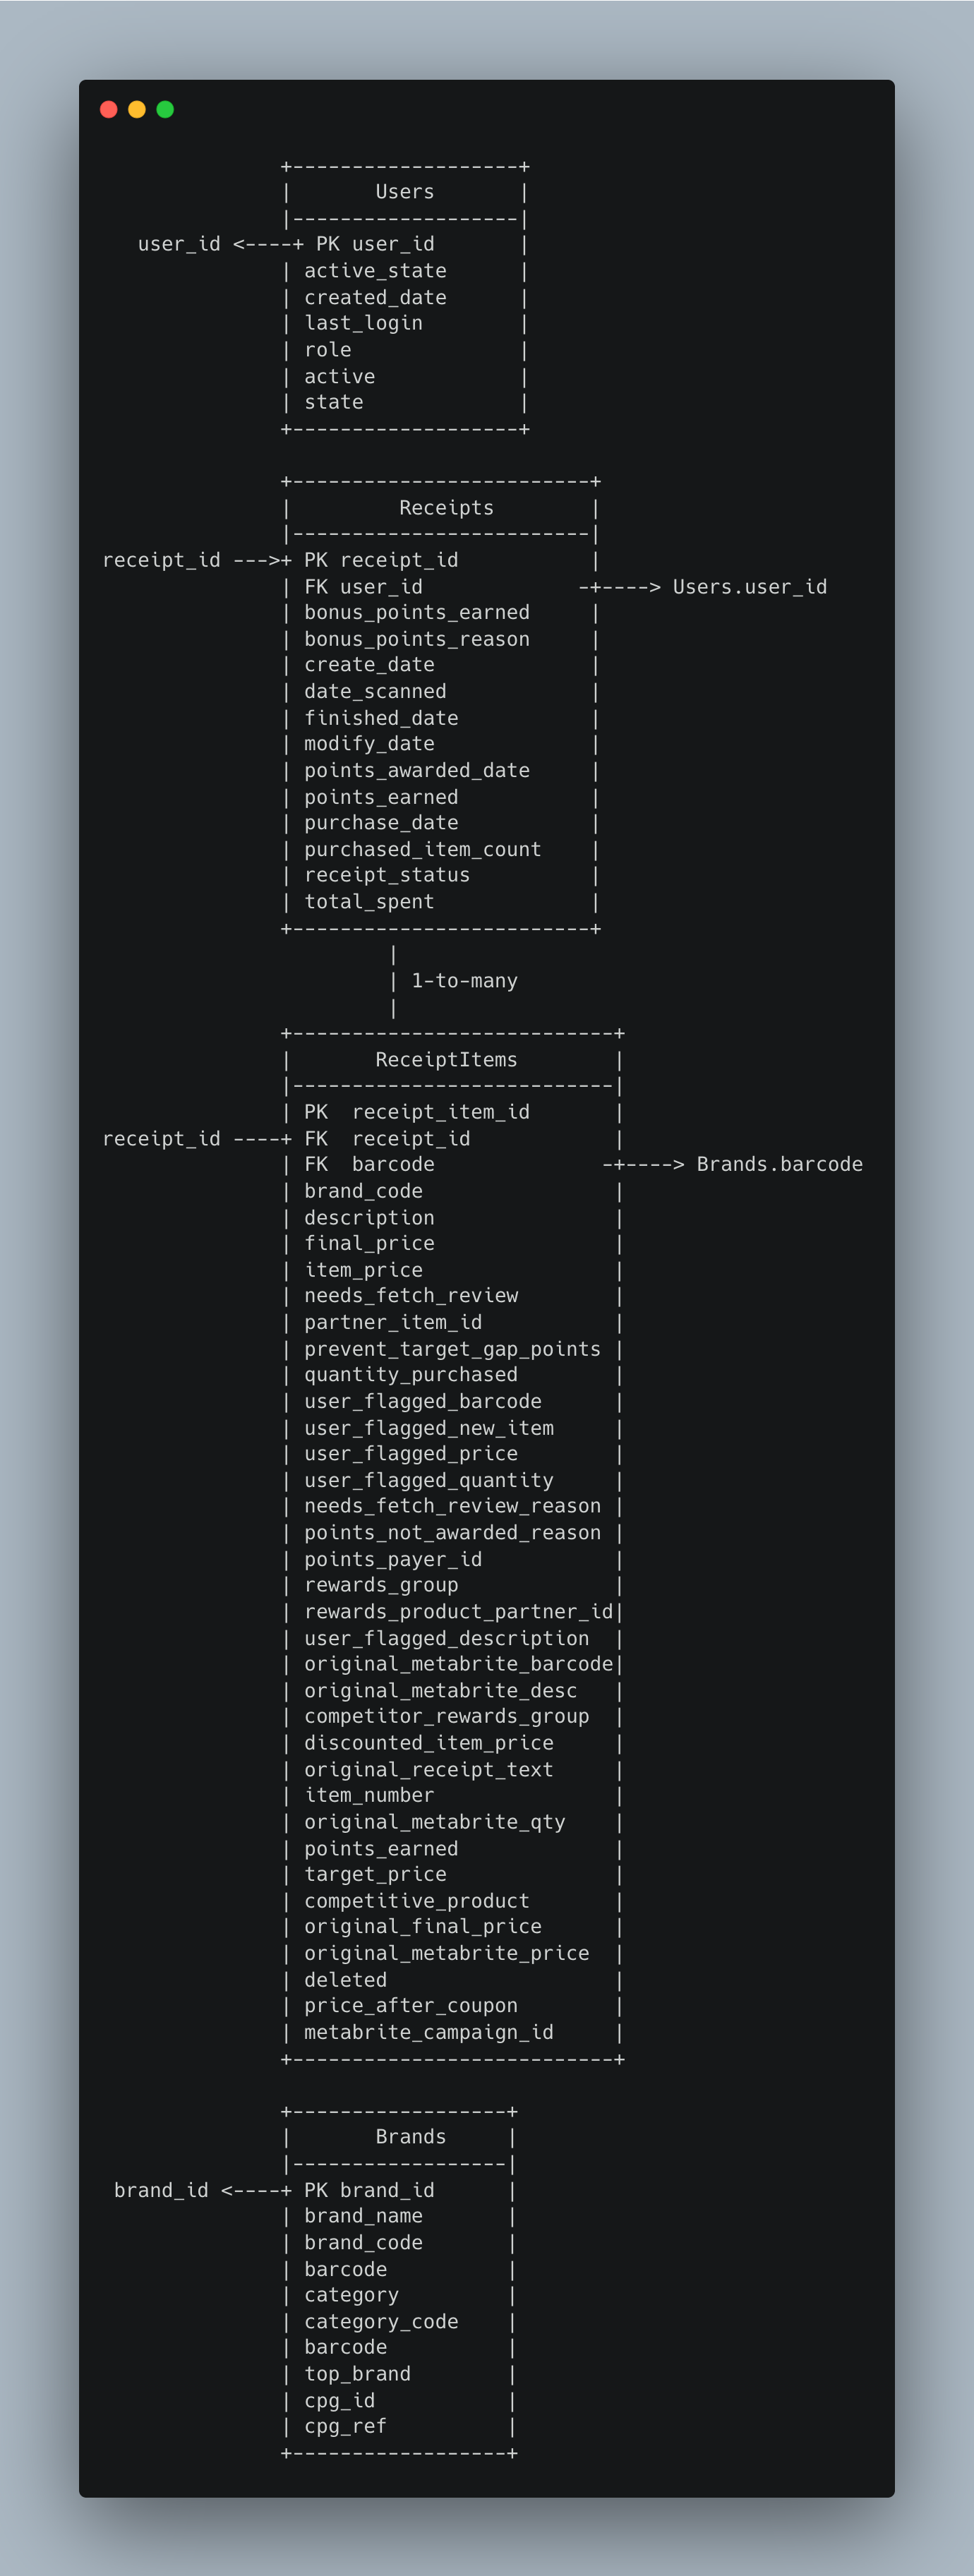

In [58]:
from IPython.display import Image, display

erd = Image(filename='./erd.png')
display(erd)

**In the above ERD**:
- Users: Holds details about the users
- Brands: Holds brand-level details for purchased items
- Receipts: One row per receipt header, capturing overall transaction metrics
- ReceiptItems:  One row per purchased line item. 
- Users and Brands are dimensions tables
- Receipts and ReceiptItems are fact tables
- We can add/remove fields as per business requirements easily

## 2. Write queries that directly answer predetermined questions from a business stakeholder
- SQL Dialect: **PostgreSQL**

### What are the top 5 brands by receipts scanned for most recent month?

```
SELECT 
  b.brand_name,
  COUNT(DISTINCT r.receipt_id) AS receipts_scanned
FROM receipts r
JOIN receipt_items ri ON r.receipt_id = ri.receipt_id
JOIN brands b ON ri.barcode = b.barcode
WHERE EXTRACT(MONTH FROM r.purchase_date::date) = EXTRACT(MONTH FROM CURRENT_DATE)
GROUP BY b.name
ORDER BY receipts_scanned DESC
LIMIT 5;
```

### How does the ranking of the top 5 brands by receipts scanned for the recent month compare to the ranking for the previous month?

```
WITH monthly_rank AS (
    SELECT 
      EXTRACT(MONTH FROM r.purchase_date::date) AS month,
      b.brand_name,
      COUNT(DISTINCT r.receipt_id) AS receipts_scanned,
      RANK() OVER (
        PARTITION BY EXTRACT(MONTH FROM r.purchase_date::date) 
        ORDER BY COUNT(DISTINCT r.receipt_id) DESC
      ) AS rank
    FROM receipts r
    JOIN receipt_items ri ON r.receipt_id = ri.receipt_id
    JOIN brands b ON ri.barcode = b.barcode
    WHERE EXTRACT(MONTH FROM r.purchase_date::date) >= EXTRACT(MONTH FROM CURRENT_DATE - INTERVAL '1 month')
    GROUP BY EXTRACT(MONTH FROM r.purchase_date::date), b.brand_name
)

SELECT 
  curr.month AS current_month,
  prev.month AS previous_month,
  curr.brand_name,
  curr.rank AS current_rank,
  prev.rank AS previous_rank
FROM monthly_rank curr
LEFT JOIN monthly_rank prev 
  ON curr.brand_name = prev.brand_name 
  AND prev.month = curr.month - 1
WHERE (curr.rank <= 5 OR prev.rank <= 5)
ORDER BY curr.rank;
```

### When considering average spend from receipts with 'rewardsReceiptStatus’ of ‘Accepted’ or ‘Rejected’, which is greater?

```
SELECT 
  receipt_status AS status,
  AVG(total_spent) AS average_spend
FROM receipts
WHERE UPPER(TRIM(receipt_status)) IN ('FINISHED', 'REJECTED')
GROUP BY receipt_status;
```

### When considering total number of items purchased from receipts with 'rewardsReceiptStatus’ of ‘Accepted’ or ‘Rejected’, which is greater?

```
SELECT 
  receipt_status AS status,
  SUM(purchased_item_count) AS total_items
FROM receipts
WHERE UPPER(TRIM(receipt_status)) IN ('FINISHED', 'REJECTED')
GROUP BY receipt_status;
```

### Which brand has the most spend among users who were created within the past 6 months?

```
SELECT 
  b.brand_name,
  SUM(ri.final_price * ri.quantity_purchased) AS total_spend
FROM users u
JOIN receipts r ON u.user_id = r.user_id
JOIN receipt_items ri ON r.receipt_id = ri.receipt_id
JOIN brands b ON ri.barcode = b.barcode
WHERE u.created_date >= CURRENT_DATE - INTERVAL '6 months'
GROUP BY b.brand_name
ORDER BY total_spend DESC
LIMIT 1;
```

### Which brand has the most transactions among users who were created within the past 6 months?

```
SELECT 
  b.brand_name,
  COUNT(DISTINCT r.receipt_id) AS transaction_count
FROM users u
JOIN receipts r ON u.user_id = r.user_id
JOIN receipt_items ri ON r.receipt_id = ri.receipt_id
JOIN brands b ON ri.barcode = b.barcode
WHERE u.created_date >= CURRENT_DATE - INTERVAL '6 months'
GROUP BY b.brand_name
ORDER BY transaction_count DESC
LIMIT 1;
```

## 3. Evaluate Data Quality Issues in the Data Provided
- The below results are derived from the **Data Analysis** section

### User data

- Duplicate data: This table had duplicate data for 283 users which can yield incorrect results in Analytics and hence should be cleaned. 
- Missing values: 'last_login', 'sign_up_source' and 'state' variables had missing values. These are not always a problem as long as the meaning of a missing value is clear. For example a missing value in the variable 'last_login' may signifiy that it's the user's first login. Whereas a missing value in the variable 'sign_up_source' isn't as clear as this signifies an unknown source.

### Brands data

- Test brands: Data includes 432 brands with 'test' in the name which seems like testing data which shouldn't be mixed with production data.
- Duplicate data: 10 brands seemed to have duplicate values for 'barcode' variable which is a foreign key in receipts data causing a problem with the JOIN. 22 records have duplicate brand name values with different brand_id, showing inconsistent mapping as well. Key fields like this shouldn't have duplicates as it leads to data integrity issues.
- Missing data: The variable 'category_code' seems to have inconsistent and missing values. Some categories that should have a category_code, don't have one. This indicates incorrect mapping at source and should be resolved for analytics.
- Inconsistent types: top_brand is a numeric boolean(float 1/0) but is meant to be boolean(T/F). 

### Receipts & Items data

- Potential void transactions: There are 450 records with 0 spend, these could signify void transactions which could be excluded or handled accordingly.
- Missing dates: There are 448 records with no 'purchase' or 'finish' date which are key fields for transaction data.
- Skewed data: Looking at distribution for numeric fields like points_earned, total_spent and purchased_item_count, this data seems to have potential outliers with values like 689 items purchased. This should be investigated. Adding data quality checks for these metrics is also a good idea.
- Missing barcode in items: The 'barcode' variable seems to be missing for certain items which is a key field to tie back to brands data. The Items data seems to be sparse in general with high missing value percentages across variables, at least half of all columns have more than 70% missing values.
- Placeholder data: Majority items have 'ITEM NOT FOUND' as the description, possible placeholder values indicating missing actual description.

## 4. Communicate with Stakeholders

#### **Subject: Data Quality & Optimization: Observations, Questions, and Next Steps**

Hello [Stakeholder Name],

I’ve been reviewing the data assets and wanted to share some key observations along with a few questions that will help us move forward. These notes are meant to highlight current data quality concerns and outline what’s needed to ensure the data is usable, scalable, and aligned with our business goals.

In terms of the architecture, we can structure the data into four main tables — Users, Receipts, Items, and Brands. This provides a clear way to track which users submitted which receipts, what items were purchased, and which brand each item belongs to.

#### Data Quality Observations
I explored each dataset using basic profiling: checking for null values, unusual patterns, duplicate values, and outliers. 
This surfaced several issues, including:
- Missing key variables
- High duplicate counts
- Potentially invalid or placeholder records
- Mixed production and test data

#### Open Questions

To address the above concerns effectively, I’d love your input on the following:
- The data seems to contain both production and test records — is this expected, or should test data be filtered out?
- How are brands and items meant to connect — is barcode the correct field for linking? What is the intended use of this data in the current product?
- Which fields are critical to the business, and which are safe to drop or impute?
- What assumptions are okay when data is missing — for example, should a null last_login indicate the user’s first login?
- How should we handle receipts that are missing user_id?
- Are we expected to ignore or correct obviously inaccurate price or points data?

#### Additional Context Requested

If available, I’d appreciate:
- Documentation on field definitions and expected value ranges
- More details on how this data is used (e.g., analytics dashboards, vendor feeds, ML models)

#### Performance & Scaling Considerations

As the volume of data grows, there are a few optimizations we may want to consider:
- Partitioning receipts by day or hour to improve query performance in the warehouse
- Building aggregate tables to reduce expensive JOINs depending on business use cases
- Monitoring data freshness and latency for real-time or near-real-time use cases

Feel free to reach out if you’d like to discuss anything in more detail. Thank you for your time, and I look forward to collaborating to improve and optimize our data assets.

Best regards,